In [1]:
import pymssql
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy  import create_engine
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  """Entry point for launching an IPython kernel.


In [2]:
############################### Database Connections ######################################
# AWS
server = 'pfidb.ci3ir6nuotoi.sa-east-1.rds.amazonaws.com'
user = 'admin'
password = 'AramLucas2020.'
db = 'pfidb'

# Local DB PC
# server = 'DESKTOP-3OHRULK'
# user = 'sa'
# password = 'welcome1'
# db = 'pfidb'

# Connection to DB
conn = pymssql.connect(server,user,password,db)

#Connection using sqlAlchemy
conn_for_insert = fr'mssql+pymssql://'+user+':'+password+'@'+server+'/'+db
engine = create_engine(conn_for_insert)

In [3]:
#Query that retrives the usage of the stations
#query = open("master_query_v3.sql","r")
#df_stations_usage = pd.read_sql_query(query.read(),conn)

stations_query = """SELECT * FROM [estaciones-de-bicicletas-publicas]"""
# stations_query = """SELECT * FROM [estaciones-bicicletas-publicas-2019]"""

df_stations = pd.read_sql(stations_query,conn)

In [5]:
lat_long = df_stations[["lat", "long"]].values
sse_df = pd.DataFrame(columns=['K','sse'])
sse = {}
for k in range(1, int(len(df_stations))+1):
    kmeans = KMedoids(n_clusters=k,random_state=0,max_iter=3000,metric="manhattan").fit(lat_long)
    sse_df = sse_df.append({'K':k, 'sse':kmeans.inertia_},ignore_index=True)
    sse[k] = kmeans.inertia_
sse_df


,K,sse
0,1.0,6.630639
1,2.0,4.488644
2,3.0,4.026058
3,4.0,3.352051
4,5.0,2.876781
...,...,...
194,195.0,0.020639
195,196.0,0.016253
196,197.0,0.012375
197,198.0,0.006799


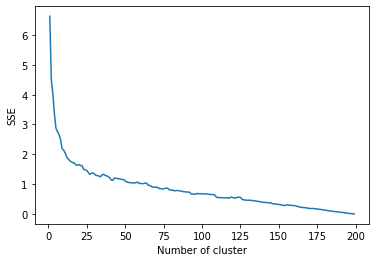

In [6]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [8]:
sse_df['variation'] = (sse_df['sse'].pct_change())*-1
i = sse_df.loc[(sse_df['variation'] <= 0.1)].index[0]
lower_limit = int(sse_df.iloc[i]['K'])
upper_limit = int(lower_limit  + round((len(df_stations)*0.1)))
print(upper_limit)

26


In [9]:
sse_df.loc[(sse_df['variation'] <= 0.1)]

,K,sse,variation
5,6.0,2.760996,0.040248
6,7.0,2.665894,0.034445
7,8.0,2.494021,0.064471
9,10.0,2.140104,0.020724
10,11.0,2.041965,0.045857
...,...,...,...
183,184.0,0.098492,-0.007905
185,186.0,0.081617,0.059621
186,187.0,0.077403,0.051638
187,188.0,0.072846,0.058874


In [6]:
silhouette = pd.DataFrame(columns=['cluster','sil_coeff'])
for n_cluster in range(lower_limit, upper_limit):
    kmeans = KMedoids(n_clusters=n_cluster,metric="manhattan",random_state=0).fit(lat_long)
#     kmeans = KMeans(n_clusters=n_cluster).fit(lat_long)
    label = kmeans.labels_
    sil_coeff = silhouette_score(lat_long, label, metric='manhattan')
    silhouette = silhouette.append({'cluster':n_cluster, 'sil_coeff':sil_coeff},ignore_index=True)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
# silhouette

For n_clusters=6, The Silhouette Coefficient is 0.30100641042806386
For n_clusters=7, The Silhouette Coefficient is 0.2637643567845438
For n_clusters=8, The Silhouette Coefficient is 0.3320654293956714
For n_clusters=9, The Silhouette Coefficient is 0.2895235739596787
For n_clusters=10, The Silhouette Coefficient is 0.3204571548794965
For n_clusters=11, The Silhouette Coefficient is 0.29836451580529005
For n_clusters=12, The Silhouette Coefficient is 0.29572501193360007
For n_clusters=13, The Silhouette Coefficient is 0.2892770042691183
For n_clusters=14, The Silhouette Coefficient is 0.28101111324427874
For n_clusters=15, The Silhouette Coefficient is 0.25666488015173927
For n_clusters=16, The Silhouette Coefficient is 0.2829298854278676
For n_clusters=17, The Silhouette Coefficient is 0.26118468588849564
For n_clusters=18, The Silhouette Coefficient is 0.24799398127120095
For n_clusters=19, The Silhouette Coefficient is 0.24107644582555637
For n_clusters=20, The Silhouette Coefficien

In [7]:
# silhouette.loc[silhouette['sil_coeff'].idxmax()]['cluster']
silhouette.sort_values('sil_coeff',ascending=False,inplace=True)

print(silhouette.loc[silhouette['cluster']>=22]['cluster'].iloc[0]) # 22 is the amount of barrios where a station is available


24.0


Automatically created module for IPython interactive environment
For n_clusters = 8 The average silhouette_score is : 0.3267186189283301


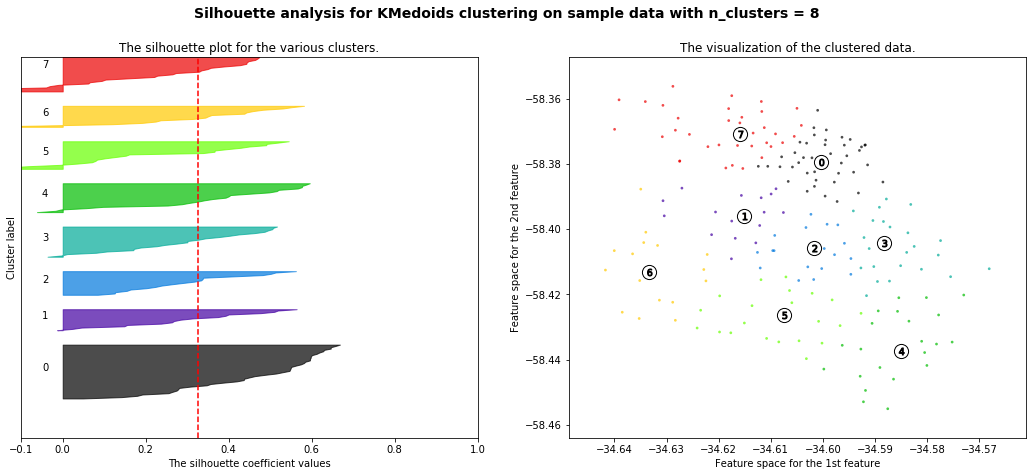

In [10]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
k_to_use = int(silhouette.loc[silhouette['sil_coeff'].idxmax()]['cluster'])
range_n_clusters = [k_to_use]
X = df_stations[["lat", "long"]].values

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    clusterer = KMedoids(n_clusters=n_clusters, random_state=0,metric="manhattan")
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMedoids clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()